## Estimating causal effect of moisture on GPP/NEE

In this notebook, we use FluxNet data to test the GPP/NEE-moisture sensitivity. 

We focus on the sites in US, AU, Mongolian and EU. 

We use GPP/NEE as Y, and first use precipitation as X, and then soil moisture as X. 

Is the confounder variable temporal or spatial? Two assumptions are both testable. 

[//]: # "the confounder could be spatial factor, such as site, local climatology, or PFTs. "

Reference: 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3479688/

https://arxiv.org/pdf/2005.08639.pdf


In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

from scipy.spatial.distance import cdist
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 200
import seaborn as sns

### Load data

Fluxnet annul data is used. See this [link](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/) for more information.

Focus on CSH, OSH, WSA, SAV, GRA PFTs.

In [2]:
# this should be read only, use Jianing's data
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'
site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)

meta_data = pd.read_csv(path_ro+'/FLUXNET_YY_metadata.csv')  
meta_data['length'] = meta_data['end_year'] - meta_data['start_year'] + 1 
meta_data = meta_data.loc[meta_data.length >= 10]
print('Number of sites with over 10 yrs data in metadata: ', len(meta_data))
meta_data.head(3)
meta_data = meta_data.copy()
# meta_data.groupby('start_year').count(), meta_data.groupby('end_year').count()


Number of sites with over 10 yrs data in metadata:  69


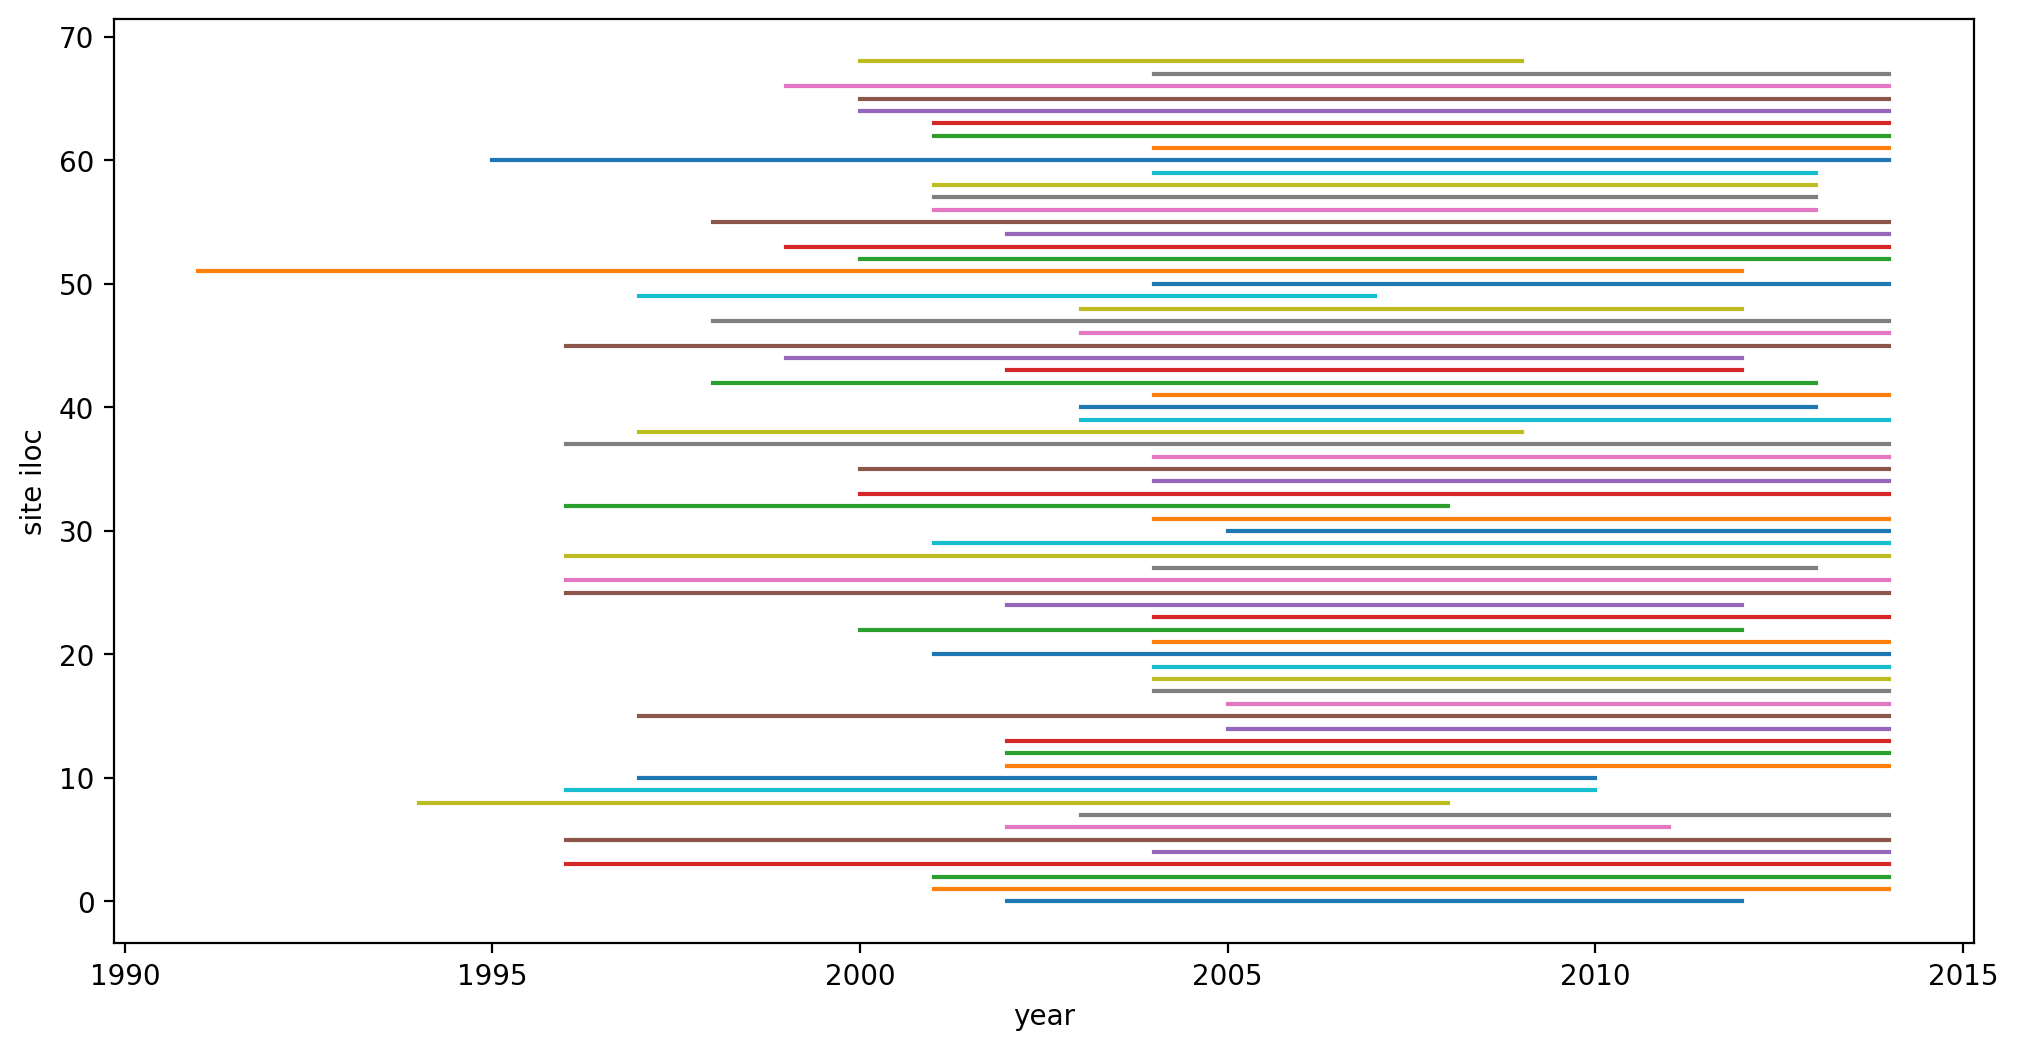

In [3]:
fig, ax = plt.subplots(figsize=(12,6))

span = []

for j,i in enumerate(meta_data.index):
   
    x1 = meta_data.loc[i].start_year
    x2 = meta_data.loc[i].end_year
    y = j # i
    # print(i, x1, x2, y)
    
    x = np.linspace(x1, x2, x2-x1+1)
    span.append(', '.join(['{:.2f}'.format(i) if type(i) == float else str(i) for i in x]))
    y = np.repeat(y, len(x))
    ax.plot(x, y)
    ax.set_xlabel('year')
    ax.set_ylabel('site iloc')

In [4]:
meta_data['span'] = span
meta_data.groupby('span').count().sort_values('SITE_ID', ascending = False)

,SITE_ID,IGBP,LAT,LONG,ELEV,MAT,MAP,start_year,end_year,length
span,,,,,,,,,,
"2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",13,13,13,13,13,13,13,13,13,13
"1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",7,7,7,7,7,7,7,7,7,7
"2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",6,6,6,6,6,6,6,6,6,6
"2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",5,5,5,5,5,5,5,5,5,5
"2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",4,4,4,4,4,4,4,4,4,4
"2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",3,3,3,3,3,3,3,3,3,3
"2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0",3,3,3,3,3,3,3,3,3,3
"2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0",3,3,3,3,3,3,3,3,3,3
"2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0",3,3,3,3,3,3,3,3,3,3


In [5]:
overlap = list(range(2004, 2015))
overlap

[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

In [6]:
meta_data = meta_data.loc[(meta_data.start_year<=2004) & (meta_data.end_year>=2014)]
sites = meta_data.SITE_ID
len(sites)

44

In [7]:
PFT = ['CSH', 'OSH', 'WSA', 'SAV', 'GRA']
CSH = meta_data.loc[meta_data.IGBP == 'CSH'].SITE_ID.values
OSH = meta_data.loc[meta_data.IGBP == 'OSH'].SITE_ID.values
WSA = meta_data.loc[meta_data.IGBP == 'WSA'].SITE_ID.values
SAV = meta_data.loc[meta_data.IGBP == 'SAV'].SITE_ID.values
GRA = meta_data.loc[meta_data.IGBP == 'GRA'].SITE_ID.values
print('Number of sites in CSH:', len(CSH), ' OSH:', len(OSH), ' WSA:', len(WSA), ' SAV:', len(SAV), ' GRA:', len(GRA))
# some sites' data is not available 
GRA = ['AT-Neu', 'CH-Fru', 'DE-Gri', 'GL-ZaH', 'US-Var', 'US-Wkg']

Number of sites in CSH: 1  OSH: 1  WSA: 3  SAV: 0  GRA: 4


In [8]:
# Use US-Ha1 and US-Var to test 
## XX stands for percentiles, CUT stands for Constant Ustar Threshold and VUT stands for Variable Ustar Threshold 

sitename = 'US-Ha1'
GPP_flag = -9999
file = os.listdir(path_ro+'/'+sitename)
print('number of files in this directory is: ', len(file))
filename = file[0]
data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)
data.head(1)
# for i in data.columns:
#     print(i)

number of files in this directory is:  1


,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
0,1991,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,8.002,...,5.49528,250.079,256.464,282.125,293.752,316.133,326.858,366.616,126.998,0.219178


data length in years from this site:  22


Text(0, 0.5, 'carbon flux')

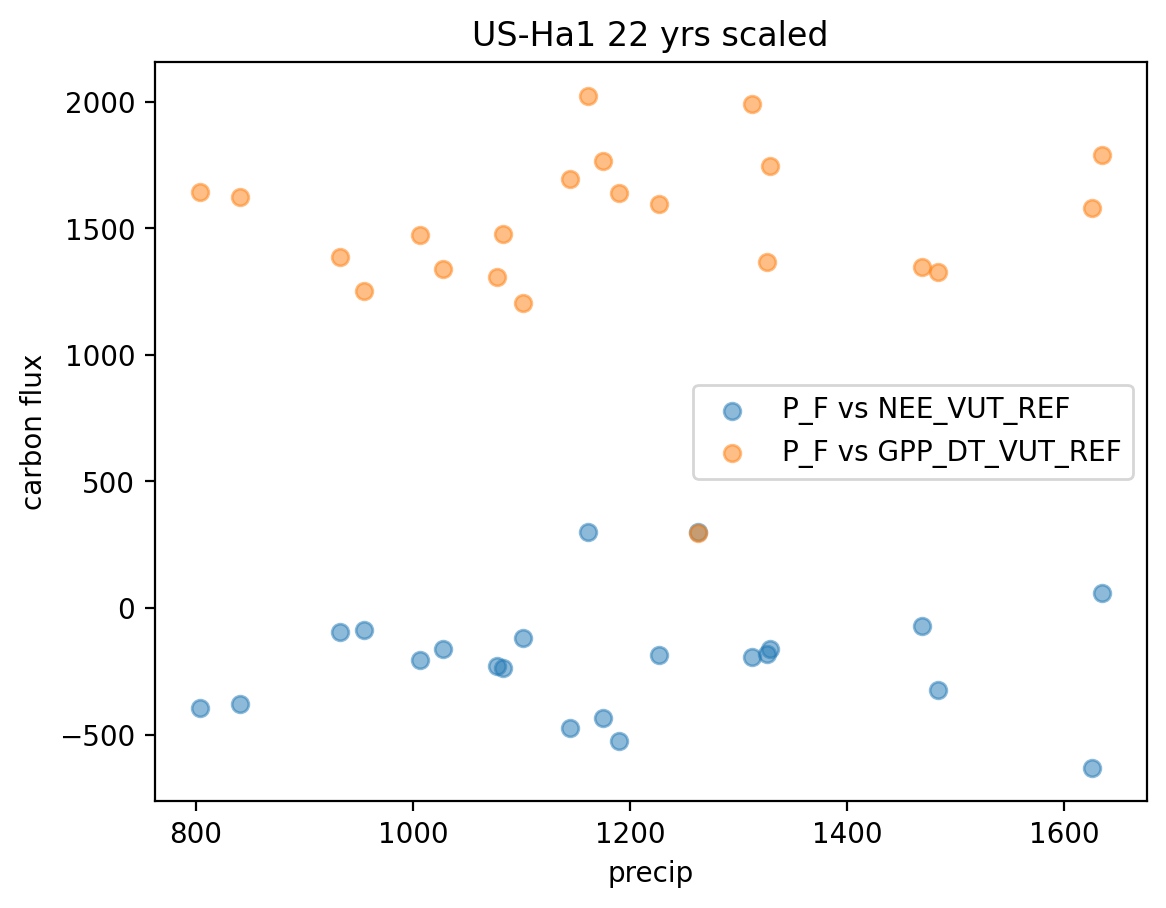

In [9]:
data = data[['GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'NEE_VUT_REF', 'P_F',]] 

# there is no soil water content in the data 'SWC_F_MDS_#'

# data = (data - data.mean())/data.std()
data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
print('data length in years from this site: ', len(data))

### plt.scatter(data.P_F, data.NEE_CUT_REF, label = 'P_F NEE CUT REF', alpha = 0.5)
plt.scatter(data.P_F, data.NEE_VUT_REF, label = 'P_F vs NEE_VUT_REF', alpha = 0.5)
plt.scatter(data.P_F, data.GPP_DT_VUT_REF, label = 'P_F vs GPP_DT_VUT_REF', alpha = 0.5)

### plt.scatter(data.P_ERA, data.NEE_CUT_REF, label = 'P_ERA NEE CUT REF', alpha = 0.5)
### plt.scatter(data.P_ERA, data.NEE_VUT_REF, label = 'P_ERA NEE VUT REF', alpha = 0.5)
plt.legend()
plt.title(sitename+' '+str(len(data))+' yrs scaled')
plt.xlabel('precip')
plt.ylabel('carbon flux')


### Merge / append all the sites data together

Different sites have different data length/sample number. Select the sites with >=10 years of data.

In [10]:
meta_data.head(3)

,SITE_ID,IGBP,LAT,LONG,ELEV,MAT,MAP,start_year,end_year,length,span
14,AU-How,WSA,-12.49430,131.15230,-9999.0,-9999.0,-9999.0,2001,2014,14,"2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0..."
21,AU-Tum,EBF,-35.65660,148.15170,1200.0,-9999.0,-9999.0,2001,2014,14,"2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0..."
26,BE-Bra,MF,51.30761,4.51984,16.0,9.8,750.0,1996,2014,19,"1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0..."


In [11]:
min_yrs = 10
GPP_flag = -9999
varname = ['P_F', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF', 'NEE_VUT_REF', 'TIMESTAMP']
path_ro = '/burg/glab/users/jf3423/data/FLUXNET_Annual'
start_yr = 2004
end_yr = 2014

site  = os.listdir(path_ro)
meta_file = list(filter(lambda f: f.endswith('.csv'), site))[0]
site.remove(meta_file)

print('Number of sites satistying the overlap tine span according to meta file: ', len(sites))

def merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag, star_yr, end_yr):
    # output data_allsites: the dataframe to contain all sites' info
    # input site: a list containing all sites' names
    # input min_yrs: minimum sample number (yr) required for each site to be include
    # input GPP_flag: use to filter missing/weird data
    
    # global data_allsites
    data_allsites = pd.DataFrame(data = None, index = None, columns = varname)
    data_allsites.index.name = 'site'
    
    ns = 0
    for sitename in site:
        # print('processing site: ', sitename)
        file = os.listdir(path_ro+'/'+sitename)
        if len(file) > 1:
            print('number of files in this directory is: ', len(file))
        filename = file[0]
        data = pd.read_csv(path_ro+'/'+sitename+'/'+filename)
        data = data[varname]
        data = data.loc[data.GPP_NT_VUT_REF != GPP_flag]
        # data = (data - data.mean())/data.std()
        # print('data length in years from this site: ', len(data))
        
        if (data.TIMESTAMP.min() <= 2004) & (data.TIMESTAMP.max() >= 2014): # len(data) >= min_yrs:
            data['site'] = sitename
            data = data.set_index('TIMESTAMP').loc[2004:2014]
            if len(data) == 11:
                data = data.reset_index().set_index('site')
                # data_allsites = data_allsites.append(data, ignore_index = False) 
                data_allsites = pd.concat([data_allsites, data])
                ns += 1
            else:
                print(sitename)
    print('Number of sites satistying the overlap tine span and has 11 yrs data: ', ns)
    return data_allsites
        
data_allsites = merge_all_sites(site, path_ro, min_yrs, varname, GPP_flag, start_yr, end_yr)
site_new = data_allsites.index.unique()

data_allsites

Number of sites satistying the overlap tine span according to meta file:  44
US-Syv
US-Los
US-WCr
Number of sites satistying the overlap tine span and has 11 yrs data:  36


,P_F,GPP_NT_VUT_REF,GPP_DT_VUT_REF,NEE_VUT_REF,TIMESTAMP
site,,,,,
DE-Geb,506.600,1289.000,1312.030,-233.3910,2004
DE-Geb,521.900,1272.410,1268.040,-90.1472,2005
DE-Geb,430.600,1432.980,1443.370,-600.7870,2006
DE-Geb,691.500,984.045,993.901,-87.2484,2007
DE-Geb,479.600,1236.540,1212.250,-296.7230,2008
...,...,...,...,...,...
DE-Gri,1226.100,1622.320,1561.390,-146.8260,2010
DE-Gri,909.700,1842.310,1701.140,-180.7740,2011
DE-Gri,884.600,1695.020,1648.820,-109.5830,2012


### Spatial confounder assumption
#### Causal effect estimation

Use site as the the hidden confounder H.

Recall the ground-truth causal effect formula for $Y$ if using OLS to estimate $Y$ from $X$:

$$
\begin{align}
f_{AVE}(X \rightarrow Y)(x) = \frac{1}{n} \sum_{i=1}^{n} (1 \ \  x) \hat{\beta}_{OLS}(X^m_i,Y^m_i) \\
\end{align}
$$



The estimated causal coefficients: a = 1435.23, b = 0.07


Text(0.5, 1.0, 'OLS fit GPP_DT_VUT_REF vs P_F')

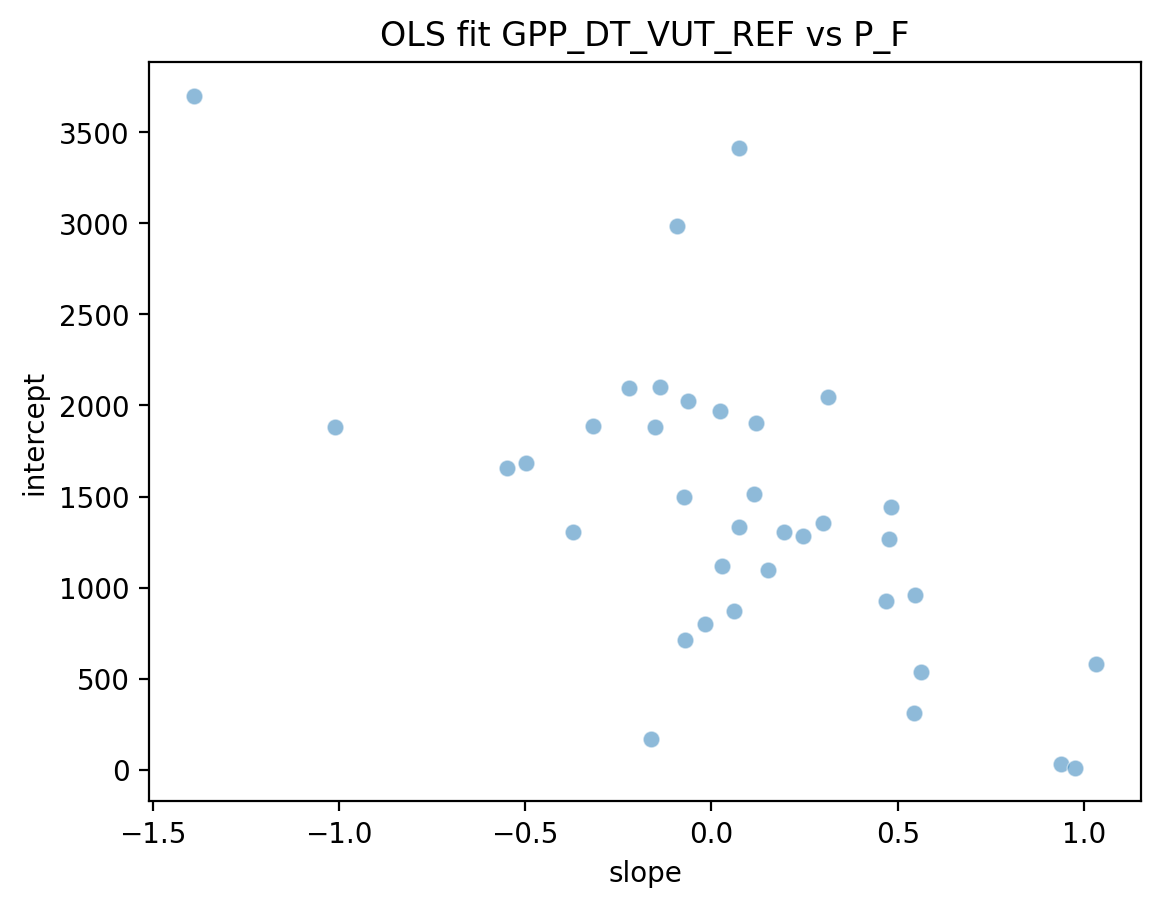

In [46]:
# estimated coefficients when we decorrelate spatial dependency (ie. compute coefficient at each location)
xname = 'P_F'
# yname = 'NEE_VUT_REF'
yname = 'GPP_DT_VUT_REF'

# this is to compute the linear regression for each site
def bhat(data_allsites, xname, yname):
    # N: site number
    results = list()
    
    site_new = data_allsites.index.unique()
    N = len(site_new) # number of sites
    
    for s, sname in enumerate(site_new):
        Xs = data_allsites.loc[sname][xname].values
        Ys = data_allsites.loc[sname][yname].values
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])
        
    return np.array(results)
    
bhat_data = bhat(data_allsites, xname, yname)
b_causal_data = np.mean(bhat_data, axis=0)
print(f"The estimated causal coefficients: a = {b_causal_data[0].item():.2f}, b = {b_causal_data[1].item():.2f}")

linedata = pd.DataFrame({'intercept': bhat_data[:, 0, 0], 'slope': bhat_data[:, 1, 0]})
sns.scatterplot(data=linedata, x = 'slope', y = 'intercept', alpha=.5, linewidth=.5,)
plt.title('OLS fit '+yname+' vs '+xname)

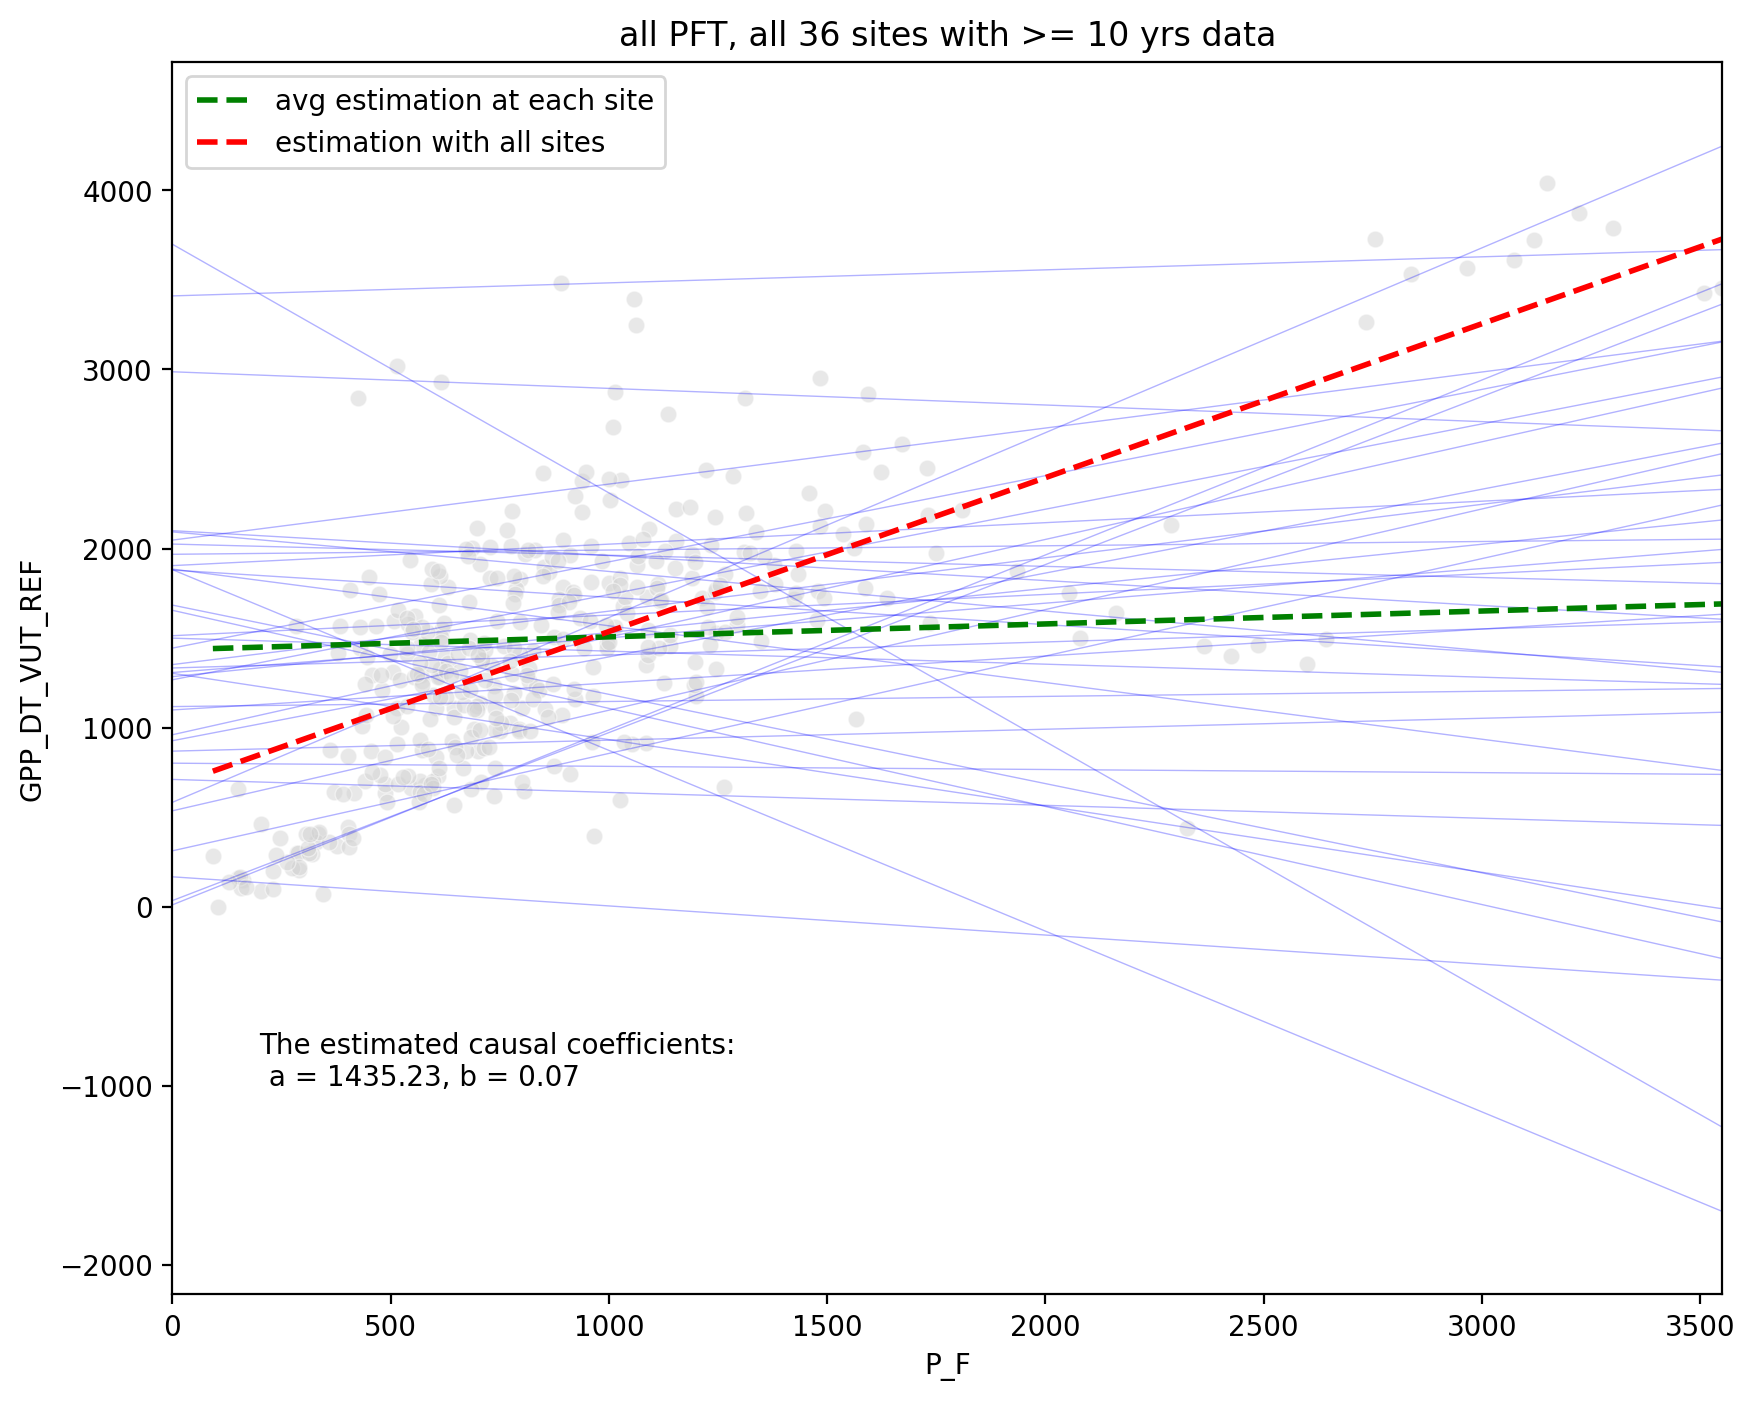

In [48]:
## red: linear regression using all data
## thin blue: linear regressions within each site/location
## green: estimate of the avg causal effect

X = data_allsites[xname].values.ravel()
Y = data_allsites[yname].values.ravel()
model = LinearRegression().fit(X.reshape(-1, 1), Y.reshape(-1, 1))
a = model.intercept_
b = model.coef_[0]
x_increments = np.arange(0,3800,100)
# x_increments = np.arange(-2,2,100)

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=data_allsites[list([xname,yname])], x=xname, y=yname, alpha=.5, color='lightgrey', ax=ax)

for i in range(bhat_data.shape[0]):
    bhat_d = bhat_data[i]
    sns.lineplot(x = x_increments, y = bhat_d[0] + x_increments * bhat_d[1], color='blue', linewidth=0.5, alpha=0.3, ax=ax)

sns.lineplot(x = X, y = b_causal_data[0] + b_causal_data[1]*X, color='green', linewidth=2, linestyle='--', label='avg estimation at each site', ax=ax)
sns.lineplot(x = X, y = a + b*X, color='red', linewidth=2, linestyle='--', label='estimation with all sites', ax=ax)

ax.set_xlabel(xname)
ax.set_xlim([0, X.max()])
ax.set_ylabel(yname)
ax.set_title('all PFT, all '+str(len(data_allsites.index.unique()))+ ' sites with >= 10 yrs data')
ax.annotate("The estimated causal coefficients: \n a = {:.2f}, b = {:.2f}".format(b_causal_data[0].item(), b_causal_data[1].item()), xy = (200, -1000))
plt.show()

### Significance test

$\hat{T}$ is the test statistic.

Let $M := m!$ and let $\sigma_1, ..., \sigma_M$ be all permutations of the elements in $\{1,2,...,m\}$.

Let $B \in N$ and let $k_1, ..., k_B$ be independent, uniform draws from $\{1, ..., M\}$.

$\sigma(x, y)$ denotes the permuted array with entries $(\sigma(x, y))^t_s = (x^t_s, y^{\sigma(t)}_s)$.

The p-value for significance test is:
$$
\begin{align}
    p_{\hat{T}}(x, y) := \frac{1+|b\in \{1, ..., B\}: \hat{T}(\sigma_{k_b})(x,y)\geq \hat{T}(x,y)|}{1+B}\\
\end{align}
$$

Null hypothesis is:
$H_0$ : $(X, Y)$ come from an LSCM with a function $f$ that is constant w.r.t. $X_t$, which formalizes the assumption of “no causal effect of $X$ on $Y$” within the LSCM framework.

https://github.com/runesen/spatio_temporal_causality/blob/master/figure_scripts/regional_effects.R

In [14]:
import random
from itertools import product
from sklearn.utils import resample
# random.sample(range(n), n)

df = data_allsites.copy()


In [56]:
# this is to compute the linear regression for each site
def bhat(data_allsites, xname, yname, b, M):
    from sklearn.utils import resample
    # N: site number
    results = list()
    
    sites = data_allsites.index.unique()
    
    if b == 0:  # actual data
        zz = np.arange(M)
    else:  # resampled data
        zz = resample(np.arange(M), replace=True)
        # zz = resample(np.arange(Xs), replace=True)
        # rng = np.random.default_rng()
        # zz = rng.choice(M, size=M, replace=False)      
    
    for s, sname in enumerate(sites):
        Xs = data_allsites.loc[sname][xname].values
        Ys = data_allsites.loc[sname][yname].values
        # if scale
        # Xs = (Xs - np.mean(Xs))/np.std(Xs)
        # Ys = (Ys - np.mean(Ys))/np.std(Ys)
        # Xs = Xs[zz]
        Ys = Ys[zz]
        model = LinearRegression().fit(Xs.reshape(-1, 1), Ys.reshape(-1, 1))
        results.append([model.intercept_, model.coef_[0]])
        
    bhat_data = np.array(results)
    
    return bhat_data[:, 1, 0]
    
# Bootstrapping
ns = df.index.nunique()
B = 999
M = 11 
N = 36
test_stats_boot = []
sites = data_allsites.index.unique()
for b in range(B + 1):
    ts = bhat(df, xname, yname, b, M)
    if len(ts) != ns:
        ts = np.full(ns, np.nan)
    test_stats_boot.append(ts)

test_stats_boot_df = pd.DataFrame(test_stats_boot, columns = sites) # columns=[f'ts_{i}' for i in range(1, ns + 1)])
# print(test_stats_boot_df)

# Function to calculate p-value
def pvfun(t, na_rm=False):
    t_data = t.loc[0]
    t_boot = t.loc[1:]
    b_non_na = np.sum(~np.isnan(t_boot))
    min_p_value = min(1, 2 * min((1 + np.sum(t_boot <= t_data)) / (1 + b_non_na), (1 + np.sum(t_boot >= t_data)) / (1 + b_non_na)))
    return min_p_value

# Apply the pvfun function to compute p-values for each province
pv = test_stats_boot_df.apply(pvfun, axis=0).reset_index()
pv.columns = ['site', 'pval']
pv['site'] = df.index.unique()
pv['Pmean'] = df.reset_index().groupby('site').mean()[xname].values
pv['length'] = df.reset_index().groupby('site').count()[xname].values
pv['coef'] = test_stats_boot_df.mean(axis=0).values
pv['PFT'] = [meta_data.loc[meta_data.SITE_ID == i]['IGBP'].values[0] for i in pv.site]
pv.sort_values('pval')

,site,pval,Pmean,length,coef,PFT
15,US-SRM,0.018,669.679091,11,-0.003775,WSA
16,US-Wkg,0.022,544.341545,11,0.002151,GRA
2,US-Ton,0.028,766.336364,11,-0.001461,WSA
7,US-Var,0.034,720.754545,11,0.002252,GRA
28,IT-Noe,0.036,523.757818,11,0.015184,CSH
11,US-Me2,0.062,541.389909,11,-0.011237,ENF
21,IT-Lav,0.064,1198.861727,11,-0.002464,ENF
33,CA-TP4,0.078,606.458455,11,0.010284,ENF
19,US-UMB,0.130,3110.492545,11,0.004418,DBF
25,CA-Gro,0.146,747.428818,11,-0.027089,MF


In [86]:
pv.loc[pv.pval <= 0.05]['site'].values, pv.loc[pv.pval <= 0.05]['PFT'].values
# sites belong to the semi-arid regions

(array(['US-Ton', 'US-Var', 'US-SRM', 'US-Wkg', 'IT-Noe'], dtype=object),
 array(['WSA', 'GRA', 'WSA', 'GRA', 'CSH'], dtype=object))

In [76]:
# test_stats_boot_df.mean(axis=1)
# test_stats_boot_df.mean(axis=0)
# test_stats_boot_df.rank().loc[0]

coef_all = test_stats_boot_df.mean(axis=1).loc[0]
print('original data avg coef at all sites', coef_all)
coef_005 = test_stats_boot_df[pv.loc[pv.pval <= 0.05]['site'].values].mean(axis=1).loc[0]
print('original data avg coef at sites with pval <=0.5', coef_005)


avg coef at all sites 0.07210276538214123
avg coef at sites with pval <=0.5 0.8104312187096717


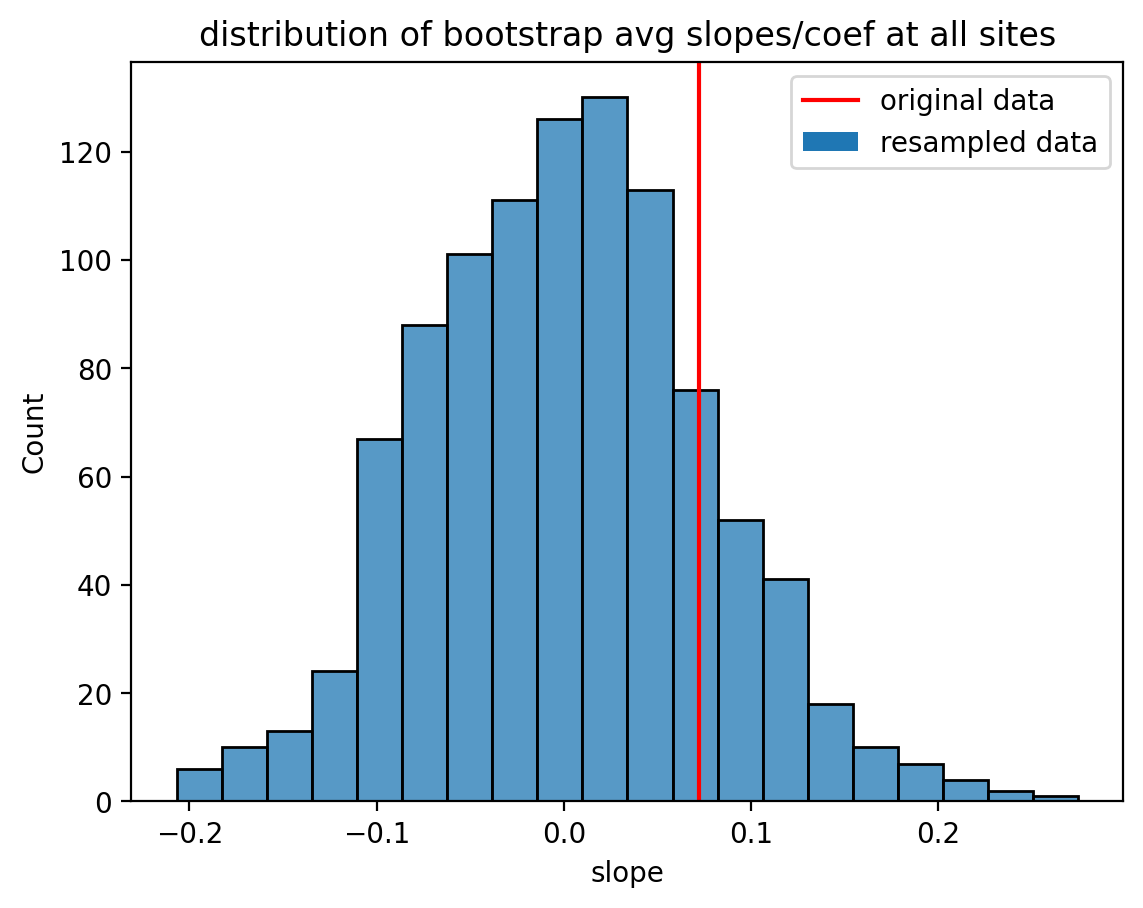

In [82]:
plt.axvline(x = test_stats_boot_df.loc[0].mean(), color='red', label = 'original data')
sns.histplot(test_stats_boot_df.mean(axis = 1), bins=20, label = 'resampled data')
plt.legend(['original data','resampled data'])
plt.xlabel('slope')
plt.title('distribution of bootstrap avg slopes/coef at all sites')
plt.show()

<AxesSubplot:xlabel='Pmean', ylabel='coef'>

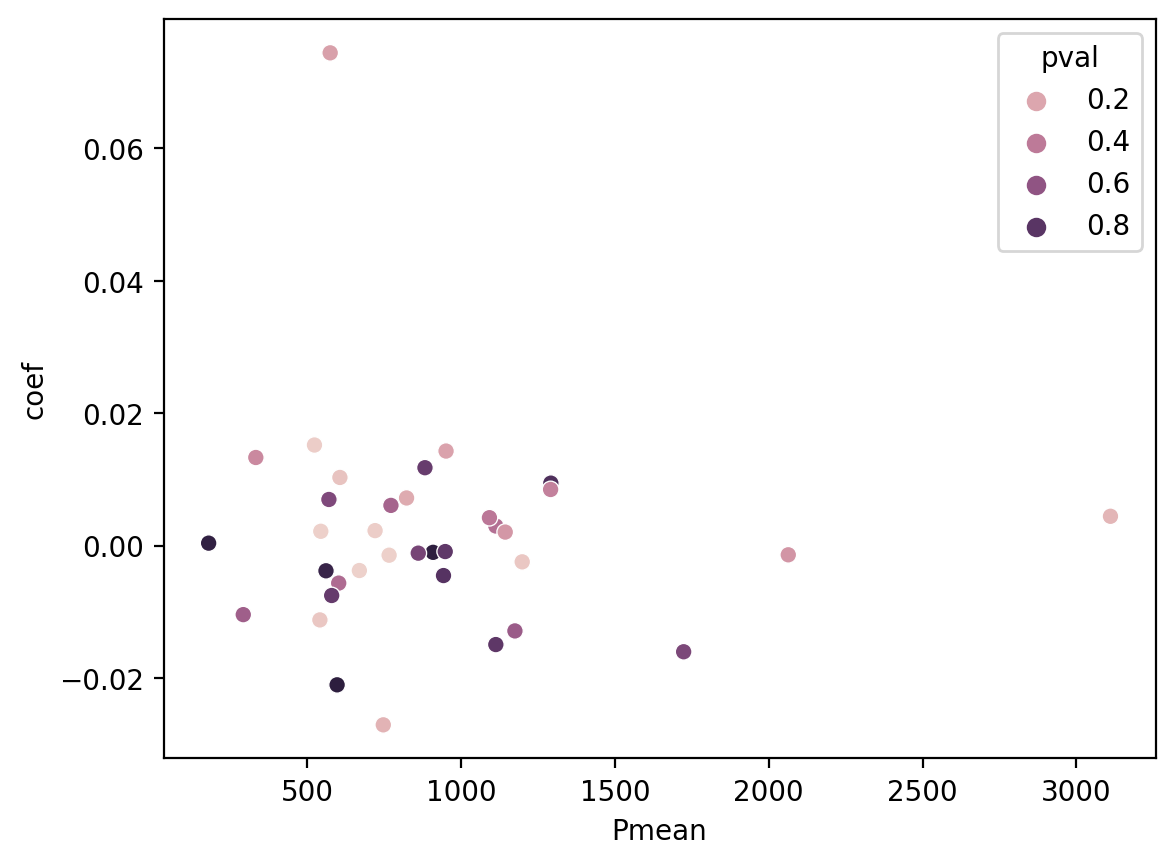

In [83]:
sns.scatterplot(data=pv, x = 'Pmean', y = 'coef', hue = 'pval')


### Temporal confounder assumption

Use ENSO index, such as Nino3.4 as the hidden confounder H. Or using ONI index: El Nino phase: 1, La Nina phase: -1, neutral phase: 0.

The temporal range does not overlap well...

In [ ]:
El = [2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2014]
La = [2008, 2011]
Ne = 

### Ecological confounder assumption
Use PFT as the hidden confounder H.

The site number with >=10 yrs data is 60. The GRA site number is 6 and the result is similar to that using all sites. The other sites' numbers belonging to CSH, OSH, WSA, and SAV are all <=3. Cannot go further in this direction.